# Изменение меток классов в задаче многоклассовой классификации с использованием данных википедии и алгоритма word2vec

Этот проект ставит перед собой очень амбициозную, и оттого немного глупую задачу улучшения разметки данных. 

Для этого предполагается использовать алгоритм word2vec. В его описании в популярных источниках зачастую можно встретить утверждения, что он осуществляет преобразование пространства слов в пространство смыслов. Это именно то, что необходимо для разумной классификации. Более того, такое преобразование позволяет вместо логистической регрессии в пространство классов применить регрессию на компоненты вектора слова, чтобы затем выбрать класс, имеющий наиболее близкий к предсказанному вектор. Кроме того, такой метод позволил бы сравнительно легко дообучать модель предсказывать новые классы, просто добавляя их в word2vec.

В качестве первичного набора данных, для которого мы хотим улучшить классификацию, используется часть набора разменных изображений imagenet с различными попродами собак, изображенных на нем. Эти данные представлены на соревновании https://www.kaggle.com/c/dog-breed-identification . Файл train.zip включает в себя архив изображеий собак. В файле labels.csv.zip записана порода собак, изображеных на картинках. Всего представлено 120 различных пород.


Word2vec тренируется на следующих наборах данных:

    1) Тексты англоязычных статей википедии о почти каждой из 120 представленных пород
    2) Тексты англоязычных статей википедии по различным тематикам, так или иначе связанным с породами собак

Все используемые данные, включая веса для word2vec и веса изображений, полученные из нейросети, можно скачать по ссылке: https://yadi.sk/d/jKtrYLoa3Pc49X. Подгружаются они из той же папки, в которой работает этот ipynb.
Сами изображения ищите на кэггле.

В качестве метрики используется точность (accuracy). Этот выбор кажется оптимальным в задаче многоклассовой классификации и, кроме того, эта метрика в некотором смысле унаследованна с конкурса на kaggle.

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from tqdm import tqdm
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.utils import layer_utils
from keras import backend as K
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import wikipedia
import stemming
import re
from stemming.porter2 import stem
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import validation_curve
import seaborn as sns

In [5]:

start = dt.datetime.now()

In [6]:
INPUT_SIZE = 224 #Размер, к котормоу преобразуются все изображения
SEED = 1987
data_dir = ''
labels = pd.read_csv(join(data_dir, 'labels.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))

(10222, 10222)


In [7]:
print np.unique(labels.breed.values)[:10]
print 'N of breeds =', len(np.unique(labels.breed.values))

['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle']
N of breeds = 120


In [8]:
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
ftrain_idx = rnd < 0.8
holdout_idx = rnd >= 0.8
y_train = labels_pivot.values

In [9]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

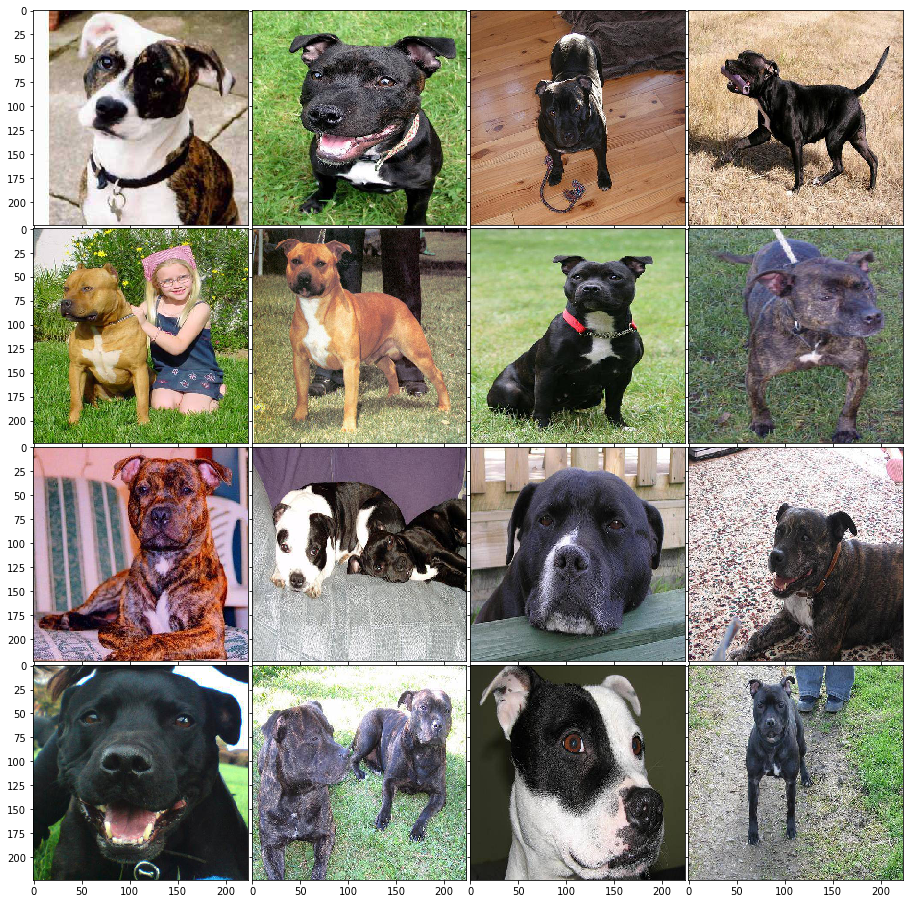

In [11]:
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
i=0
for img_id, breed in zip(labels.id.values, labels.breed.values):
    if breed!='staffordshire_bullterrier': continue
    #if breed!='eskimo_dog': continue
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    i+=1
    if i==16: break
plt.show()

# Извлекаем веса из одного из предпоследних слоев VGG16
Лучше не запускать этот кусок кода, если у вас нет лишних 8 часов времени

In [15]:
INPUT_SIZE = 224
POOLING = 'avg'
MAX_LEN = len(labels['id']) 
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
for n_file in range(11):
    x_train = np.zeros((min(n_file*1000+1000, MAX_LEN)-n_file*1000, INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
    for i, img_id in tqdm(enumerate(labels['id'][n_file*1000:min(n_file*1000+1000, MAX_LEN)])):
        img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
        x_train[i] = preprocess_input(np.expand_dims(img, axis=0))

    train_vgg_bf = vgg_bottleneck.predict(x_train, batch_size=32, verbose=1)
    np.savetxt('vgg16_bweights_train_full'+str(n_file)+'.txt', train_vgg_bf)
    del train_vgg_bf
    del x_train
    del img

1000it [00:07, 141.01it/s]


1000/1000 [==============================] - 782s   


1000it [00:06, 147.08it/s]


1000/1000 [==============================] - 778s   


1000it [00:05, 178.19it/s]


1000/1000 [==============================] - 779s   


1000it [00:05, 174.89it/s]


1000/1000 [==============================] - 790s   


1000it [00:05, 178.05it/s]


1000/1000 [==============================] - 779s   


1000it [00:06, 150.25it/s]


1000/1000 [==============================] - 779s   


1000it [00:05, 173.84it/s]


1000/1000 [==============================] - 779s   


1000it [00:05, 180.84it/s]


1000/1000 [==============================] - 778s   


1000it [00:05, 186.72it/s]


1000/1000 [==============================] - 781s   


1000it [00:06, 162.10it/s]


1000/1000 [==============================] - 778s   


221it [00:01, 193.65it/s]


1000/1000 [==============================] - 777s   


vgg16_bweights_train_full[0-10] is data set of the full available photos, e.g. 100+ breeds, 10222 dogs. 

На данный момент мы имеем 512D мерное пространство признаков. Но, так-как веса данного классификатора изначально были тренированы на всем многообразии классов из imagenet, значительная часть этих признаков будет для нас совершенно бесполезна. Сделаем PCA преобразование, чтобы уменьшить их количество.

Визуальный анализ распределения этих признаков самих по себе не имеет никакого смысла, так-как это признаки, сформированные довольно глубокой нейронной сетью на пикселях изображения.

In [10]:
# загрузим зписанные в файл веса
vgg_bf = []
for i in range(11):
    vgg_bf.extend(np.loadtxt('vgg16_bweights_train_full'+str(i)+'.txt'))
vgg_bf=np.array(vgg_bf)
vgg_bf_holdout = vgg_bf[holdout_idx]
vgg_bf = vgg_bf[ftrain_idx]

In [11]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(vgg_bf))
train_idx=[i<0.8 for i in rnd]
valid_idx=[i>=0.8 for i in rnd]
train_vgg_bf = vgg_bf[train_idx]
valid_vgg_bf = vgg_bf[valid_idx]

In [12]:
vgg_scaler = StandardScaler()
train_vgg_bfs = vgg_scaler.fit_transform(train_vgg_bf)
valid_vgg_bfs = vgg_scaler.transform(valid_vgg_bf)
hold_vgg_bfs = vgg_scaler.transform(vgg_bf_holdout)

Number of the principal components for 95% dispersion finesse is 270


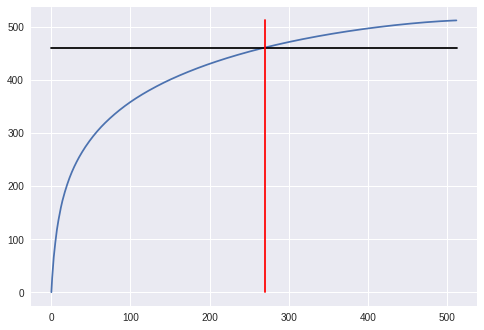

In [13]:
pca = PCA(random_state=137, n_components=train_vgg_bf.shape[1])
X_t = pca.fit_transform(train_vgg_bfs)

disp=[0]
for nd in range(X_t.shape[1]):
    ar = [i[nd] for i in X_t]
    me = np.mean(ar)
    disp.append(disp[-1]+sum([(i-me)**2 for i in ar])/X_t.shape[0])

n=0
for i in disp:
    if(disp[-1]*0.9<i): break
    n+=1
print 'Number of the principal components for 95% dispersion finesse is', n

plt.plot(range(len(disp)), disp)
plt.plot([0,len(disp)], [0.9*disp[-1],0.9*disp[-1]], c='black')
plt.plot([n,n], [0,disp[-1]], c='red')
plt.show()

Кривая дисперсии растет довольно медленно, поэтому мы вынужденны сохранить более половины признаков.

In [14]:
train_vgg_bfP = [i[:273] for i in pca.transform(train_vgg_bfs)]
valid_vgg_bfP = [i[:273] for i in pca.transform(valid_vgg_bfs)]
vgg_bfP = [i[:273] for i in pca.transform(vgg_scaler.transform(vgg_bf))]
hold_vgg_bfP = [i[:273] for i in pca.transform(hold_vgg_bfs)]

Давайте проверим качество простого классификатора на этих данных. Целью данного проекта будет побить именно эту цифру, используя дополнительную информацию.

In [15]:
breed_dict={}
for i in np.unique(labels.breed.values): breed_dict[i]=len(breed_dict)+1
y = np.array([breed_dict[i] for i in labels.breed.values[ftrain_idx]])
logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', random_state=137, C=1)
logreg.fit(vgg_bfP, y)
Cs = np.logspace(-5, -1, 20)
val_train, val_test = validation_curve(logreg, vgg_bfP, y,'C', Cs, cv=2, scoring='accuracy', verbose=1)

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.7min finished


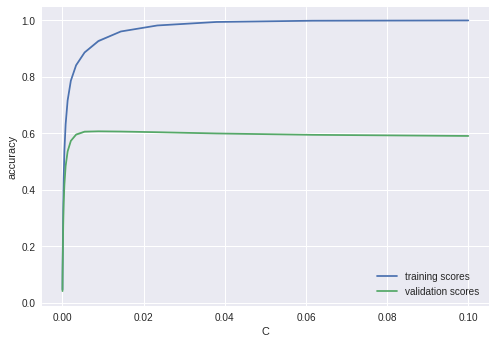

In [331]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
    facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(Cs, val_train, label='training scores')
plot_with_err(Cs, val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('accuracy')
plt.legend()

Также проверим качество классификации с использованием всех компонент

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  6.8min finished


0.606876554739 0.682715506926


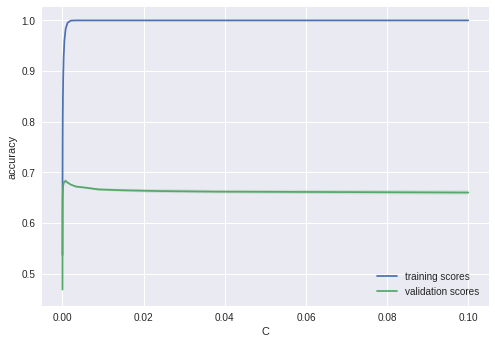

In [332]:
val_train2, val_test2 = validation_curve(logreg, vgg_bf, y,'C', Cs, cv=2, scoring='accuracy', verbose=1)

plot_with_err(Cs, val_train2, label='training scores')
plot_with_err(Cs, val_test2, label='validation scores')
plt.xlabel('C'); plt.ylabel('accuracy')
plt.legend()

print max(val_test.mean(1)), max(val_test2.mean(1))

Видно, что даже 95% дисперсии оказалось недостаточным для полноценной классификации - РСА ухудшает точность на 7%. 
Точность на холдауте совпадает.

In [336]:
logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', random_state=137, C=0.01)
logreg.fit(vgg_bf, y)
print('Accuracy on holdout {}'.format(accuracy_score(
    logreg.predict(vgg_bf_holdout), [breed_dict[i] for i in labels.breed.values[holdout_idx]])))

Accuracy on holdout 0.681556195965


# Получение весов word2vec

Для начала займемся парсингом статей из википедии. К счстью для этого есть простая и удобная библиотека wikipedia. 

Сделаем ва прохода: 
    
    В одном пройдем по всем статьям, выпадающим в поиске при запросе интересующей нас породы. В этом 
    случае, например, для породы saint bernard в нашу выборку попадает так же статья о святом Бернарде.
    
    В другом сделаем так, чтобы на каждую породу приходилась ровно 1 статья. К сожалению для этого пришлось 
    провести ручгую разметку половины пород.
    
Также в обоих случаях все входящие слова приводятся к нижнему регистру и лемматизируются. Все символы(включая числа) также убраны.

In [20]:
breeds = np.unique(labels.breed)

list_of_weird_breeds = {
    'african_hunting_dog' : 'African wild dog',
    'appenzeller' : 'Appenzeller Sennenhund', 
    'basset' : 'Basset Hound',
    'black-and-tan_coonhound' :'Black and Tan Coonhound',
    'blenheim_spaniel' : 'Cavalier King Charles Spaniel',
    'bluetick' : 'Bluetick Coonhound',
    'boston_bull' : 'Boston Terrier', 
    'boxer' : 'Boxer (dog)', 
    'brabancon_griffon': 'Griffon Bruxellois', 
    'brittany_spaniel' : 'Brittany dog', 
    'bull_mastiff' : 'Bullmastiff', 
    'cardigan' : 'Cardigan Welsh Corgi',
    'chihuahua' : 'Chihuahua (dog)', 
    'clumber': 'Clumber Spaniel',
    'curly-coated_retriever' : 'Curly Coated Retriever', 
    'dandie_dinmont' : 'Dandie Dinmont Terrier', 
    'doberman' : 'Doberman Pinscher', 
    'english_springer' : 'English Springer Spaniel',
    'entlebucher' : 'Entlebucher Mountain Dog',
    'eskimo_dog' : 'Husky',
    'german_short-haired_pointer' : 'German Shorthaired Pointer', 
    'groenendael' : 'Groenendael dog', 
    'japanese_spaniel' : 'Japanese Chin', 
    'malamute' : 'Alaskan Malamute', 
    'mexican_hairless' : 'Mexican Hairless Dog',
    'miniature_poodle' : 'Poodle', 
    'newfoundland' : 'Newfoundland dog',
    'papillon' : 'Papillon dog',
    'pekinese' : 'Pekingese', 
    'pembroke' : 'Pembroke Welsh Corgi',
    'pomeranian' : 'Pomeranian dog',
    'redbone' : 'Redbone Coonhound',
    'scotch_terrier' : 'Scottish Terrier', 
    'shih-tzu' : 'Shih Tzu',
    'silky_terrier' : 'Australian Silky Terrier', 
    'standard_poodle' : 'Poodle',
    'staffordshire_bullterrier': 'staffordshire bull terrier',
    'saint_bernard' : 'St. Bernard (dog)',
    'samoyed' : 'Samoyed dog', 
    'toy_poodle' : 'Poodle', 
    'walker_hound' : 'Treeing Walker Coonhound',
    'wire-haired_fox_terrier' : 'Wire Fox Terrier', 
    }

rejected_words = []

def GetWikiText(breed): # Get text of one wiki page per breed
    topic = ''
    for i in wikipedia.search(breed):
        if (breed.replace('_', ' ') == i.lower()):
            topic = i
            break
    if breed in list_of_weird_breeds.keys():
        topic = list_of_weird_breeds[breed]
    if topic=='':
        print 'Somethig is wrong with breed', breed, 'Try these: ', wikipedia.search(breed)
        return []
    try: pag = wikipedia.page(topic).content
    except wikipedia.DisambiguationError: 
        print 'Topic ', topic, ' for the breed ',  breed, ' include multiple entries. Here is the list: ', wikipedia.search(topic)
        return []
    sentences = pag.lower().rsplit('.')         #lower text and split on sentences
    sentences = [[stem(word) for word in re.sub('\W+',' ', sentence).rsplit(' ')] 
                 for sentence in sentences]     #remove not alphabet/numbers, split on words
    sentences = [[word for word in sentence if (word not in rejected_words)&(word!='')] 
                 for sentence in sentences]     #choose only entries of our vocab
    return sentences

def GetWikiRaw(breed): # Get text of all relevant to the breed pages
    text = []
    print '|', breed,
    for topic in wikipedia.search(breed):
        try: pag = wikipedia.page(topic).content
        except wikipedia.DisambiguationError: 
            print topic, 
            continue
        sentences = pag.lower().rsplit('.')         #lower text and split on sentences
        sentences = [[stem(word) for word in re.sub('\W+',' ', sentence).rsplit(' ')] 
                     for sentence in sentences]     #remove not alphabet/numbers, split on words
        sentences = [[word for word in sentence if (word not in rejected_words)&(word!='')] 
                     for sentence in sentences]     #choose only entries of our vocab
        text.extend(sentences)
    return text

In [ ]:
text = []
a=[text.extend(GetWikiText(i)) for i in breeds]

Посмотрим на наиболее часто встречающиеся в статьях слова

In [144]:
word_dict={}
for sentence in text:
    for word in sentence:
        if word not in word_dict: word_dict[word]=1
        else: word_dict[word]=word_dict[word]+1
print [i[0] for i in sorted([(i, word_dict[i]) for i in word_dict], key=lambda i: i[1])[-30:]]

[u'can', u'were', u'this', u'not', u'at', u'their', u'on', u's', u'have', u'from', u'they', u'was', u'by', u'or', u'that', u'for', u'it', u'be', u'with', u'are', u'as', u'breed', u'is', u'dog', u'to', u'a', u'in', u'of', u'and', u'the']


К сожалению для нашего собачьего датасета уже 30 самых популярных слов включают слова 'dog', 'breed', а среди 50 самых популярных начинают встречаться названия самих пород. С другой стороны мы можем вычеркнуть слова. встретившиея всего раз, а таких 5700. И вот список исключенных наиболее частых слов:

In [152]:
rejected_words = [u'can', u'were', u'this', u'not', u'at', u'their', u'on', u's', u'have', u'from', 
                  u'they', u'was', u'by', u'or', u'that', u'for', u'it', u'be', u'with', u'are', u'as', 
                  u'is', u'to', u'a', u'in', u'of', u'and', u'the']
rejected_words.extend([i[0] for i in sorted([(i, word_dict[i]) for i in word_dict], key=lambda i: i[1]) if i[1]<=1])

In [153]:
print len(rejected_words), len(word_dict)

5737 13081


Повторим ту же процедуру для статей более широкой тематики

In [133]:
textR = []
a=[textR.extend(GetWikiRaw(i)) for i in breeds]

| affenpinscher | afghan_hound

/home/petr/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /home/petr/anaconda2/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


 Tazi Afghan (disambiguation) | african_hunting_dog Wild dog (disambiguation) | airedale | american_staffordshire_terrier Staffordshire Terrier Pitbull (disambiguation) | appenzeller Appenzell (disambiguation) | australian_terrier | basenji | basset Basset | beagle | bedlington_terrier Rothbury (disambiguation) | bernese_mountain_dog Bernese (disambiguation) | black-and-tan_coonhound Black and tan (disambiguation) | blenheim_spaniel | bloodhound Bloodhound (disambiguation) | bluetick | border_collie Shep | border_terrier | borzoi | boston_bull | bouvier_des_flandres Bouvier | boxer | brabancon_griffon Smousje | briard | brittany_spaniel | bull_mastiff | cairn | cardigan Cardigan | chesapeake_bay_retriever CBR | chihuahua Chihuahua | chow | clumber Clumber | cocker_spaniel | collie | curly-coated_retriever CCR | dandie_dinmont | dhole | dingo Dingo (disambiguation) | doberman Doberman (disambiguation) | english_foxhound | english_setter Llywelyn (disambiguation) | english_springer | ent

In [135]:
word_dict={}
for sentence in textR:
    for word in sentence:
        if word not in word_dict: word_dict[word]=1
        else: word_dict[word]=word_dict[word]+1
print [i[0] for i in sorted([(i, word_dict[i]) for i in word_dict], key=lambda i: i[1])[-50:]]

[u'one', u'most', u'year', u'been', u'group', u'coat', u'show', u'can', u'work', u'kennel', u'use', u'has', u'but', u'he', u'other', u'his', u'which', u'this', u'also', u'an', u'club', u'not', u'their', u'were', u'have', u'they', u'at', u'or', u'from', u'terrier', u'on', u's', u'be', u'that', u'it', u'by', u'are', u'for', u'with', u'was', u'breed', u'as', u'is', u'dog', u'to', u'a', u'in', u'of', u'and', u'the']


In [140]:
rejected_wordsR = [u'one', u'most', u'year', u'been', u'group', u'coat', u'show', u'can', u'work', u'kennel', u'use',
                   u'has', u'but', u'he', u'other', u'his', u'which', u'this', u'also', u'an', u'club', u'not', 
                   u'their', u'were', u'have', u'they', u'at', u'or', u'from', u'on', u's', u'be', u'that', u'it', 
                   u'by', u'are', u'for', u'with', u'was', u'as', u'is', u'to', u'a', u'in', u'of', u'and', u'the']
rejected_wordsR.extend([i[0] for i in sorted([(i, word_dict[i]) for i in word_dict], key=lambda i: i[1]) if i[1]<=2])

In [143]:
print len(rejected_wordsR), len(word_dict)

 17822 32899


In [16]:
def saveWikiText(filename, text, rejected=[]):
    #text2write=''
    #for sent in text:
    #    for word in sent:
    #        if word in rejected: continue
    #        text2write+=' '+word
    #    text2write+='.'
    #text_file = open(filename, "w")
    #text_file.write(text2write)
    #text_file.close()
    with open(filename,'w') as f:
        pickle.dump([[word for word in sent if word not in rejected] for sent in text],f)
    
    
def loadWikiText(filename, rejected=[]):
    #text_file = open(fname, "r")
    #newtext = text_file.read()
    #text_file.close()

    #sentences = newtext.rsplit('.')
    #text = [i.rsplit(' ') for i in newtext.rsplit('.')]
    #text = [[j for j in i if j!=''] for i in text]
    #text = [i for i in text if len(i)]
    text=[]
    with open(filename,'r') as f:
        text = pickle.load(f)
    text1=[]
    for sentence in tqdm(text):
        if len(sentence)==0: continue
        text1.append([j for j in sentence if(j!='')&(j not in rejected)])
    return text1

In [165]:
saveWikiText('wiki_text1.txt', text)
saveWikiText('wiki_text_raw.txt', textR)

In [173]:
saveWikiText('wiki_text_rejected.txt', [rejected_words, rejected_wordsR])

In [17]:
rejected_words, rejected_wordsR = loadWikiText('wiki_text_rejected.txt')
text  = loadWikiText('wiki_text1.txt', rejected_words)
textR = loadWikiText('wiki_text_raw.txt', rejected_wordsR)

100%|██████████| 61723/61723 [06:16<00:00, 163.84it/s]


Натренируем word2vec на наших выборках. Здесь нам придется сделать некоторое допущение: многие породы собак состоят более чем из 1 слова, поэтому небходио решить: складывать векторы этих слов, или складвать и делить на N. Далее проверка будет проводиться для обоих этих вариантов

In [18]:
def train_WV(text, breeds, freq_words=['']):
    model = Word2Vec(text, min_count=1)
    word_vectors = model.wv
    del model
    breed2vec={}
    breed2vecN={}
    for breed in breeds:
        lwords = breed.replace('_', ' ').replace('-', ' ').rsplit(' ')
        lwords = [stem(word) for word in lwords if stem(word) not in freq_words]
        lwords = [word_vectors[word] for word in lwords if word in word_vectors.vocab]
        if len(lwords)==0:
            print 'Problem with breed', breed
            continue
        dog_vec = [sum([word[i] for word in lwords]) for i in range(len(lwords[0]))]
        breed2vec[breed]=dog_vec
        dog_vec = [sum([word[i] for word in lwords])/float(len(lwords)) for i in range(len(lwords[0]))]
        breed2vecN[breed]=dog_vec
    return breed2vec, breed2vecN

In [21]:
breed2vec, breed2vecN = train_WV(text, breeds)
breed2vecR, breed2vecRN = train_WV(textR, breeds)

Problem with breed pekinese


In [22]:
print 'Number of the dog\'s space dimensions:', len(breed2vec.values()[0])

Number of the dog's space dimensions: 100


Итого мы имеем 4 набора различных меток, каждый из которых имеет размерность 100. На самом деле уже сейчас это некоторый прогресс, так-как в случае многоклассового классификатора он бы, по сути, имел дело с пространством размерности 120 и метками вида (0, 0, ... 0, 1, 0, ... 0, 0). Но попробуем сделать PCA преобразование полученных векторов.

Важно отметить: в пространстве векторов слов работает евклидова метрика для определения их похожести, поэтому нормировать их перед трансформацией нельзя.

In [23]:
def dog_voc_transformator(breed2vec):
    voc_vals=breed2vec.values()
    dog_pca = PCA(random_state=137, n_components=len(voc_vals[0]))
    X_t = dog_pca.fit_transform(voc_vals)

    disp=[0]
    for nd in range(X_t.shape[1]):
        ar = [i[nd] for i in X_t]
        me = np.mean(ar)
        disp.append(disp[-1]+sum([(i-me)**2 for i in ar])/X_t.shape[0])

    n=0
    for i in disp:
        if(disp[-1]*0.99<i): break
        n+=1
    print 'Number of the principal components for 99% dispersion finesse is', n
    
    n=0
    for i in disp:
        if(disp[-1]*0.9<i): break
        n+=1
    print 'Number of the principal components for 90% dispersion finesse is', n

    plt.plot(range(len(disp)), disp)
    plt.plot([0,len(disp)], [0.9*disp[-1],0.9*disp[-1]], c='black')
    plt.plot([n,n], [0,disp[-1]], c='red')
    plt.show()
    
    return X_t, dog_pca

Number of the principal components for 99% dispersion finesse is 3
Number of the principal components for 90% dispersion finesse is 2


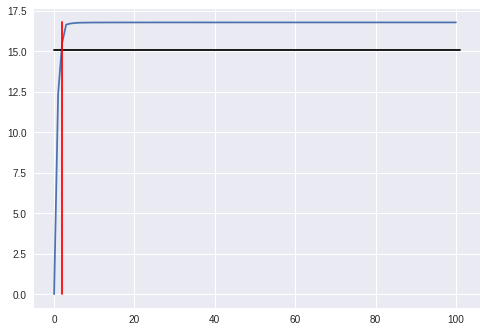

In [24]:
X_t, dog_pca = dog_voc_transformator(breed2vec)

Проверим, что метрика сохранилась:

In [25]:
print np.sqrt(sum([ (i[0]-i[1])**2 for i in zip(breed2vec.values()[0],breed2vec.values()[1])]))
print np.sqrt(sum([ (i[0]-i[1])**2 for i in zip(X_t[0],X_t[1])]))

2.1358264548
2.1358264548


Number of the principal components for 99% dispersion finesse is 4
Number of the principal components for 90% dispersion finesse is 3


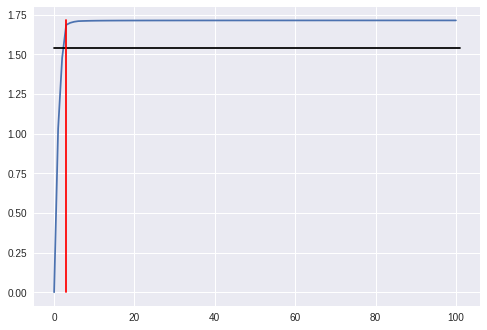

In [26]:
XN_t, dog_pcaN = dog_voc_transformator(breed2vecN)

Number of the principal components for 99% dispersion finesse is 19
Number of the principal components for 90% dispersion finesse is 8


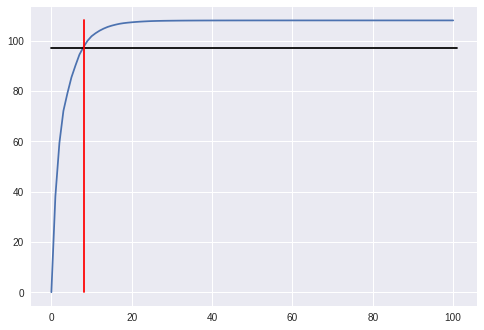

In [27]:
XR_t, dog_pcaR = dog_voc_transformator(breed2vecR)

Number of the principal components for 99% dispersion finesse is 22
Number of the principal components for 90% dispersion finesse is 10


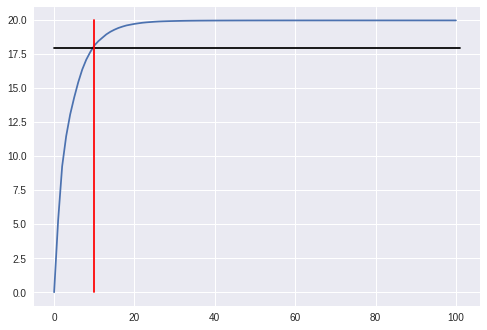

In [28]:
XRN_t, dog_pcaRN = dog_voc_transformator(breed2vecRN)

Видно, что вектора собак образуют подпространство существенно меньшей размерности. При этом для узкого набора статей из википедии размерность этого пространства оказывается всего лишь около 4, тогда как для широкого набора статей это число в районе 20. При этом сложно сказать, какой из этих результатов для нас лучше: с одной стороны малое число компонент упрощает классификатор и снижает вероятность переобучения. Сдругой стороны на большом числе компонент можно, вероятно, добиться лучших реультатов

Посмотрим на то, как выглядит распределение пород в проекции на первые 2 компоненты

In [ ]:
plt.scatter([i[0] for i in X_t], [i[1] for i in X_t],[i[2] for i in X_t])
plt.show()

Тут видна доволно интересная структура кластеров, однако давайте посмотрим повнимательнее на крайний правый из них

In [63]:
for i in zip(X_t, breed2vec.keys()):
    if i[0][0]>8: print i[1]

german_short-haired_pointer
west_highland_white_terrier
greater_swiss_mountain_dog
wire-haired_fox_terrier


Видно, что его образовали собаки с большим числом слов в названии. Вероятно причина возникновения других кластеров аналогична. Такое разделение не имеет смысла, поэтому просто забудем про не отнормированные векторы.

Посмотрим, как выглядят кластеры для нормированных векторов.

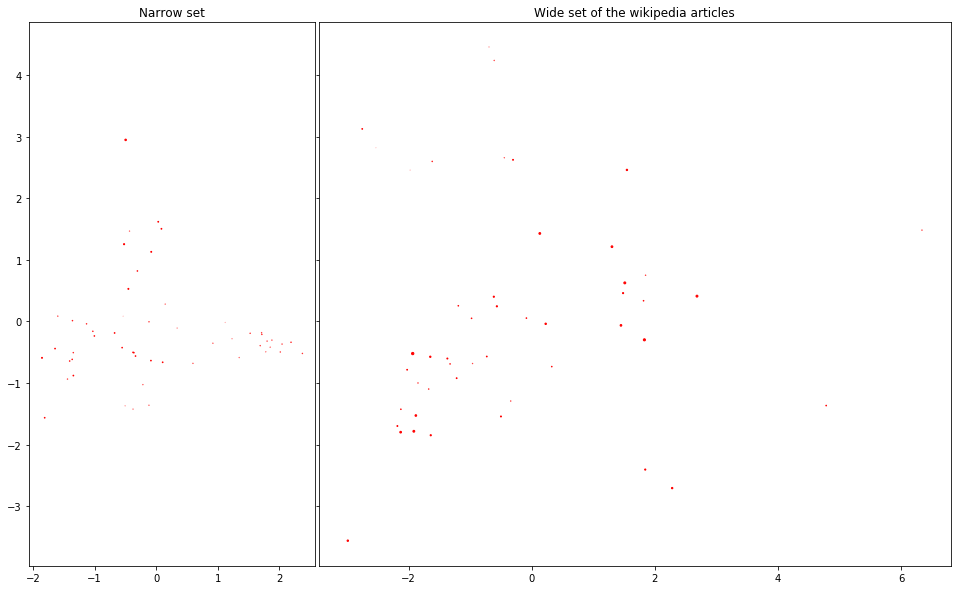

In [75]:
fig = plt.figure(1, figsize=(20, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.05)
grid[0].scatter([i[0] for i in XN_t], [i[1] for i in XN_t],[i[2] for i in XN_t], color='r')
grid[0].set_title('Narrow set')
grid[1].scatter([i[0] for i in XRN_t],[i[1] for i in XRN_t],[i[2] for i in XRN_t], color='r')
grid[1].set_title('Wide set of the wikipedia articles')
plt.show()

На первый взгляд меньшая выборка статей дает более интересную структуру кластеров. Но не стоит забывать, что у широкой выборки статей существенный процент дисперсии приходится и на другие компоненты.

In [30]:
breed2vecN_PCA3,breed2vecN_PCA10 = {}, {}
for j,breed in enumerate(breed2vec):
    breed2vecN_PCA3[breed]  = XN_t[j][:3]
    breed2vecN_PCA10[breed] = XN_t[j][:10]

breed2vecRN_PCA10,breed2vecRN_PCA20 = {}, {}
for j,breed in enumerate(breed2vecR):
    breed2vecRN_PCA10[breed] = XRN_t[j][:10]
    breed2vecRN_PCA20[breed] = XRN_t[j][:20]

Теперь, когда все данные обработаны, можно начинать делать предсказания.

Сейчас у нас есть следующие датасеты:
Векторы собак: breed2vecN_PCA3, breed2vecN_PCA10, breed2vecRN_PCA10, breed2vecRN_PCA20 

Предобработанные изображения: vgg_bf and vgg_bfP

Для того, чтобы делать предсказания будем  делать регрессию из фич изображения в компоненты векторов пород, а затем выбирать самую ближайшую породу. Этот подход позволит в будующем делать и вероятностные предсказания, ставя вероятность каждой из породы пропорционально расстоянию от предсказанной точки до нее.

В такой ситуации очевидным выбором для метрики является квадрат ошибки, 
Так-как в пространстве слов работает евклидова метрика, которая является суммой квадаратов расстояний для каждой из компонент, то наилучшей метрикой для классификатора будет квадрат ошибки.

In [34]:
voc_names = ['breed2vecN_PCA10', 'breed2vecN_PCA3', 'breed2vecRN_PCA10', 'breed2vecRN_PCA20']
img_names = ['vgg_bfP', 'vgg_bf']

for img_iter, img_fea in enumerate([vgg_bfP, vgg_bf]):
    for voc_iter, b2v in enumerate([breed2vecN_PCA10, breed2vecN_PCA3, breed2vecRN_PCA10, breed2vecRN_PCA20]):
        
        print('Dataset: '+voc_names[voc_iter]+', '+img_names[img_iter])
        
        y = np.array([b2v[i] for i in labels.breed.values[ftrain_idx] if i in b2v])       #координаы векторов собак для регрессии
        img_fea1 = np.array(img_fea)[np.array([(i in b2v) for i in labels.breed.values[ftrain_idx]])] #предобработанные изображения
        target = np.array([i for i in labels.breed.values[ftrain_idx] if i in b2v])   #таргет для измерения точности на валидации
        
        np.random.seed(seed=SEED)
        rnd = np.random.random(len(y))
        train_idx=[i<0.8 for i in rnd]
        valid_idx=[i>=0.8 for i in rnd]

        y_train = y[train_idx]              
        y_valid = y[valid_idx]
        X_train = img_fea1[train_idx]
        X_valid = img_fea1[valid_idx]
        target_train = target[train_idx]
        target = target[valid_idx]
        
        #breed_dict={}
        #for i in np.unique(target): breed_dict[i]=len(breed_dict)
        #target = np.array([breed_dict[i] for i in target])
        #target_tr = target[train_idx]
        #target = target[[not i for i in train_idx]]
        
        predictions = []
        predictions_train = []
        for n in range(len(y_train[0])):
            regressor1 = LinearRegression()
            regressor1.fit(X_train, [j[n] for j in y_train])
            prediction = regressor1.predict(X_valid)
            predictions.append(prediction)
            prediction = regressor1.predict(X_train)
            predictions_train.append(prediction)
        predictions = [[i[n] for i in predictions] for n in range(len(predictions[0]))]
        predictions_train = [[i[n] for i in predictions_train] for n in range(len(predictions_train[0]))]
        
        #valid_probs=[]
        valid_preds=[]
        for vect in predictions:
            distances = [(i, np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[i],vect)]))) for i in b2v]
            valid_preds.append(sorted(distances, key=lambda i: i[1])[0][0])
        #    sumd=sum([i[1] for i in distances])
        #    valid_probs.append([i[1]/sumd for i in distances])
        #print('LogLoss {}'.format(log_loss(target, valid_probs)))
        print('Accuracy {}'.format(accuracy_score(target, valid_preds)))
        
        train_preds=[]
        for vect in predictions_train:
            distances = [(i, np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[i],vect)]))) for i in b2v]
            train_preds.append(sorted(distances, key=lambda i: i[1])[0][0])
        print('Accuracy on train {}'.format(accuracy_score(target_train, train_preds)))
        
        #regressor2 = Ridge()
        print '_____________________________________________________________________________'

Dataset: breed2vecN_PCA10, vgg_bfP
Accuracy 0.0248484848485
Accuracy on train 0.024583787148
_____________________________________________________________________________
Dataset: breed2vecN_PCA3, vgg_bfP
Accuracy 0.0230303030303
Accuracy on train 0.0214719153571
_____________________________________________________________________________
Dataset: breed2vecRN_PCA10, vgg_bfP
Accuracy 0.0474759615385
Accuracy on train 0.0602223594812
_____________________________________________________________________________
Dataset: breed2vecRN_PCA20, vgg_bfP
Accuracy 0.0546875
Accuracy on train 0.0762816553428
_____________________________________________________________________________
Dataset: breed2vecN_PCA10, vgg_bf
Accuracy 0.0272727272727
Accuracy on train 0.035164151237
_____________________________________________________________________________
Dataset: breed2vecN_PCA3, vgg_bf
Accuracy 0.0224242424242
Accuracy on train 0.0328302473938
________________________________________________________

Лучшее, чего смогла добиться голая регрессия это точность в 7.8%. Очень плохой результат, по сравнению с 67% точностью простого классификатора. Однако это намного лучше, чем случайный классификатор, для которого точность была бы порядка 1/120, то есть около 1%.

При этом видно, что какого-то сильного переобучения на трейне нет. Очевидно, что линейной регрессии попросту не хватает и в этой задаче нужно, как минимум, добавить полиномиальные признаки и строить новую регрессию, или же строить леса.

Кроме того стоит отметить, что PCA преобразование в этой задаче показывает себя не слишком эффективно. Обрезание 5% дисперсии отрезает более 10% от точности. Вероятно предобработанные изображения вообще не нужно преобразовывать, а от вектора собак оставить еще больш компонент - порядка 30-40.

Учитывая количество признаков (512 до и 273 после РСА) количество полниномиальных признаков превысит 50000, что не очень хорошо... Построение леса в такой ситуации кажется более простой задачей

Давайте, для начала, посмотрим, кого же мы сейчас путаем

In [105]:
print zip(target, valid_preds)[:20]

[('borzoi', 'whippet'), ('basenji', 'schipperke'), ('shetland_sheepdog', 'scottish_deerhound'), ('redbone', 'vizsla'), ('bedlington_terrier', 'dandie_dinmont'), ('golden_retriever', 'clumber'), ('irish_water_spaniel', 'clumber'), ('dhole', 'dhole'), ('dingo', 'samoyed'), ('giant_schnauzer', 'dandie_dinmont'), ('bloodhound', 'scottish_deerhound'), ('miniature_schnauzer', 'dandie_dinmont'), ('welsh_springer_spaniel', 'scottish_deerhound'), ('lakeland_terrier', 'boston_bull'), ('airedale', 'scottish_deerhound'), ('mexican_hairless', 'vizsla'), ('irish_terrier', 'scottish_deerhound'), ('airedale', 'shih-tzu'), ('miniature_schnauzer', 'boston_bull'), ('lhasa', 'shih-tzu')]


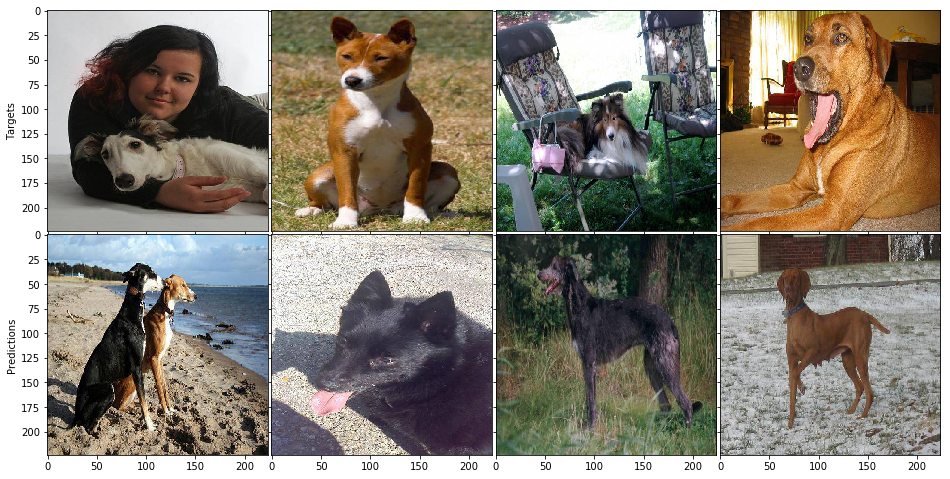

In [104]:
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.05)
i=0
for img_id, breed in zip(labels.id.values, labels.breed.values):
    for i in range(4):
        if breed==valid_preds[i]: 
            ax = grid[i+4]
            img = read_img(img_id, 'train', (224, 224))
            ax.imshow(img / 255.)
        if breed==target[i]: 
            ax = grid[i]
            img = read_img(img_id, 'train', (224, 224))
            ax.imshow(img / 255.)
        i+=1
        if i>500: break
grid[0].set_ylabel('Targets')
grid[4].set_ylabel('Predictions')
plt.show()

В целом собаки на картинках кажутся довольно похожими, что не может не радовать. Это значит, что word2vec выдает довольно осмысленные значения для предсказаний, и они как-то корелируют с тем, как на самом деле выглядят собаки.

In [35]:
img_fea = vgg_bf
b2v = breed2vecRN_PCA20
y = np.array([b2v[i] for i in labels.breed.values[ftrain_idx] if i in b2v])       #координаы векторов собак для регрессии
img_fea1 = np.array(img_fea)[np.array([(i in b2v) for i in labels.breed.values[ftrain_idx]])] #предобработанные изображения
target = np.array([i for i in labels.breed.values[ftrain_idx] if i in b2v])   #таргет для измерения точности на валидации

np.random.seed(seed=SEED+1)
rnd = np.random.random(len(y))
train_idx=[i<0.8 for i in rnd]
valid_idx=[i>=0.8 for i in rnd]

y_train = y[train_idx]              
y_valid = y[valid_idx]
X_train = img_fea1[train_idx]
X_valid = img_fea1[valid_idx]
target_train = target[train_idx]
target = target[valid_idx]
        
predictions = []
predictions_train = []
for n in range(len(y_train[0])):
    regressor1 = LinearRegression()
    regressor1.fit(X_train, [j[n] for j in y_train])
    prediction = regressor1.predict(X_valid)
    predictions.append(prediction)
    prediction = regressor1.predict(X_train)
    predictions_train.append(prediction)
predictions = [[i[n] for i in predictions] for n in range(len(predictions[0]))]
predictions_train = [[i[n] for i in predictions_train] for n in range(len(predictions_train[0]))]
        
valid_preds=[]
ldistances=[]
for vect, trg in zip(predictions,target):
    distances = sorted([(i, np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[i],vect)]))) for i in b2v], key=lambda i: i[1])
    valid_preds.append(distances[0][0])
    distance_to_trg = np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[trg],vect)]))
    if(distances[0][1]!=0): ldistances.append([distances[0][1], distance_to_trg/distances[0][1], distances[1][1]/distances[0][1]])
print('Accuracy {}'.format(accuracy_score(target, valid_preds)))

train_preds=[]
for vect in predictions_train:
    distances = [(i, np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[i],vect)]))) for i in b2v]
    train_preds.append(sorted(distances, key=lambda i: i[1])[0][0])
print('Accuracy on train {}'.format(accuracy_score(target_train, train_preds)))

Accuracy 0.0751262626263
Accuracy on train 0.115619280049


При этом точность довольно сильно скачет в зависимости от разбиения на трейн и тест. Два разных сида выдают результат 6.8% и 7.5% соответственно. Данных довольно мало для того, чтобы эта задача выдавала стабильный результат.

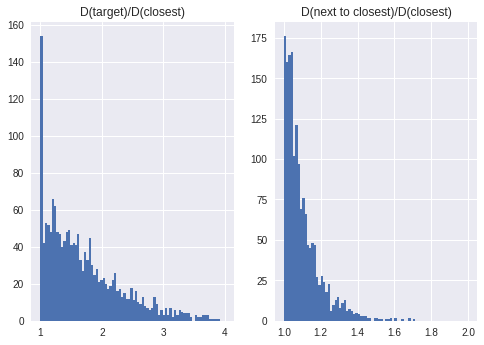

In [339]:
plt.figure(1)
plt.subplot(121)
plt.hist([i[1] for i in ldistances], bins=80, range=[1,4])
plt.title('D(target)/D(closest)')

plt.subplot(122)
plt.hist([i[2] for i in ldistances], bins=80, range=[1,2])
plt.title('D(next to closest)/D(closest)')
plt.show()

Представить себе распределение дистанций между объектами в 20-мерном пространстве довольно сложно, поэтому сравним дистанцию до объекта, следующего после ближайшего, и до таргета, отнормировав их на дитанцию до ближайшего объекта. При этом видно, что ошибается регрессор зачастую очень сильно, так-как дисперсия этих распределений отличается во много раз. Однако, при взгляде на левую картинку становится видно, что она скорее похожа на сумму двух распределений: узкого и широкого. То есть регрессор, скорее всего, довольно успешно обучился на какие-то породы собак(какой-то кластер в пространстве word vectors), но очень плохо предсказывает другие. Проверим это предположение.

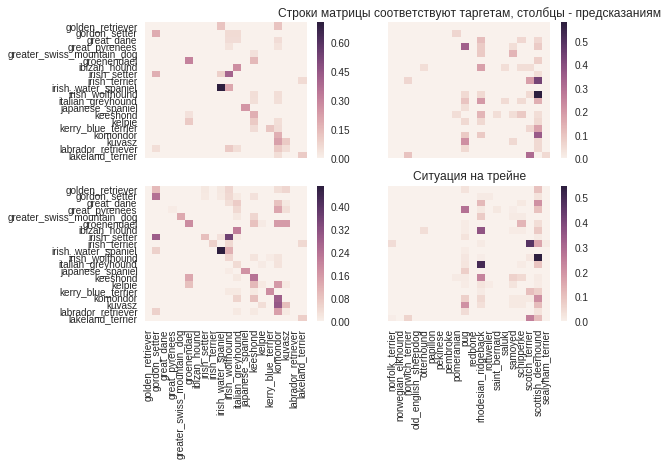

In [208]:
N1=50 #количество показанных пород
N2=70

matrice = [[0 for i in range(121)] for j in range(121)]
for i in zip(target,valid_preds):
    matrice[breed_dict[i[0]]][breed_dict[i[1]]]+=1

matrice_labels = ['' for i in range(121)]
for j in breed_dict.keys():
    matrice_labels[breed_dict[j]]=j
    tot=sum([i==j for i in target])
    for i in breed_dict.keys():
        matrice[breed_dict[j]][breed_dict[i]]/=float(tot)

matrice_train = [[0 for i in range(121)] for j in range(121)]
for i in zip(target_train,train_preds):
    matrice_train[breed_dict[i[0]]][breed_dict[i[1]]]+=1

for j in breed_dict.keys():
    tot=sum([i==j for i in target_train])
    for i in breed_dict.keys():
        matrice_train[breed_dict[j]][breed_dict[i]]/=float(tot)
        
plt.figure(2)
plt.subplot(221)
sns.heatmap([i[N1:N2] for i in matrice[N1:N2]], yticklabels=matrice_labels[N1:N2], xticklabels='')
plt.subplot(222)
sns.heatmap([i[80:100] for i in matrice[N1:N2]], xticklabels='', yticklabels='')
plt.title(u'Строки матрицы соответствуют таргетам, столбцы - предсказаниям')

plt.subplot(223)
sns.heatmap([i[N1:N2] for i in matrice_train[N1:N2]], xticklabels=matrice_labels[N1:N2], yticklabels=matrice_labels[N1:N2])
plt.subplot(224)
sns.heatmap([i[80:100] for i in matrice_train[N1:N2]], xticklabels=matrice_labels[80:100],yticklabels='')
plt.title(u'Ситуация на трейне')
plt.show()

Вот хорошй пример. Классификатор относительно хорошо научился предсказывать некоторые классы, например irish water spaniel и japanese spaniel.
В то время, как irish wolfhound ошибочно называется scottish deerhound, а irish setter путается с irish wolfhound. 

Но, что самое интересное, ситуация на трейне и тесте абсолютно идентична. Может быть эту проблему можно решить простой перестановкой строк?

In [36]:
bayesian = {}
for i in zip(train_preds, target_train):
    if i[0] not in bayesian:
        bayesian[i[0]] = np.array([0]*121)
    bayesian[i[0]][breed_dict[i[1]]]+=1

changer ={}
for i in bayesian:
    maximal=0
    bestbreed =''
    arr = bayesian[i]
    for breed in breed_dict:
        if(bayesian[i][breed_dict[breed]]<=maximal): continue
        maximal=bayesian[i][breed_dict[breed]]
        bestbreed=breed
    changer[i]=bestbreed

for breed in breed_dict:
    if breed not in changer:
        changer[breed]=breed

print('Accuracy on train {}'.format(accuracy_score(target_train, [changer[i] for i in train_preds])))
print('Accuracy on valid {}'.format(accuracy_score(target, [changer[i] for i in valid_preds])))

Accuracy on train 0.163056741916
Accuracy on valid 0.116792929293


Точность немного выростает от такого преобразования...

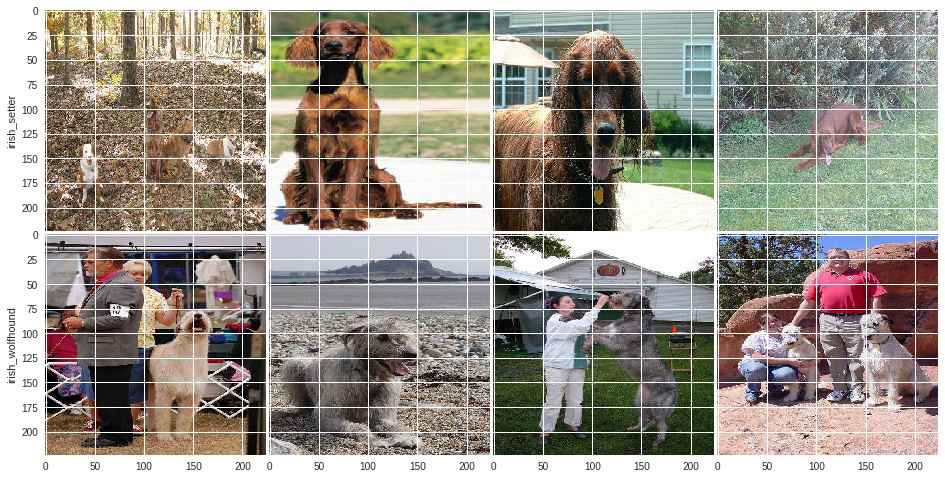

In [189]:
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.05)
i=0
j=0
for img_id, breed in zip(labels.id.values, labels.breed.values):
        if breed=='irish_setter': 
            if i==4: continue
            ax = grid[i]
            img = read_img(img_id, 'train', (224, 224))
            ax.imshow(img / 255.)
            i+=1
        if breed=='irish_wolfhound': 
            if j==4: continue
            ax = grid[j+4]
            img = read_img(img_id, 'train', (224, 224))
            ax.imshow(img / 255.)
            j+=1
        if i+j==8: break
grid[0].set_ylabel('irish_setter')
grid[4].set_ylabel('irish_wolfhound')
plt.show()

Не самые похожие породы, но, кажется, классификатор нашел какое-то качество в изображении, которое предсказывает, что собака именно ирландская. 

In [32]:
def calc_word_accuracy(word):
    acc=0.
    tot=0.
    for breed in zip(target, valid_preds):
        if word in breed[0].split('_'): 
            if word in breed[1].split('_'): acc+=1
        if word not in breed[0].split('_'): 
            if word not in breed[1].split('_'): acc+=1
        tot+=1.
    print 'Accuracy of', word, '=', acc/tot
calc_word_accuracy('irish')
calc_word_accuracy('japanese')
calc_word_accuracy('scottish')
calc_word_accuracy('wolfhound')
calc_word_accuracy('setter')
calc_word_accuracy('spaniel')

Accuracy of irish = 0.935697115385
Accuracy of japanese = 0.984375
Accuracy of scottish = 0.893629807692
Accuracy of wolfhound = 0.947115384615
Accuracy of setter = 0.972956730769
Accuracy of spaniel = 0.952524038462


In [239]:
def calc_word_accuracy_logistic2(word):
    y = np.array([breed_dict[i] for i in labels.breed.values])
    logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', random_state=137, C=0.05) 
    # C выбрано исходя из валидационной кривой в начале
    logreg.fit(np.array(vgg_bfP)[train_idx], y[train_idx])
    log_pred = logreg.predict(np.array(vgg_bfP)[valid_idx])
    log_targ = y[valid_idx]
    target2word={}
    for breed in breed_dict: target2word[breed_dict[breed]]=int(word in breed.split('_'))
    log_targ = [target2word[i] for i in log_targ]
    log_pred = [target2word[i] for i in log_pred]
    print 'Accuracy for word', word, '=', accuracy_score(log_pred, log_targ)
    
calc_word_accuracy_logistic2('irish')
calc_word_accuracy_logistic2('japanese')
calc_word_accuracy_logistic2('scottish')
calc_word_accuracy_logistic2('wolfhound')
calc_word_accuracy_logistic2('setter')
calc_word_accuracy_logistic2('spaniel')

Accuracy for word irish = 0.979856115108
Accuracy for word japanese = 0.996642685851
Accuracy for word scottish = 0.992326139089
Accuracy for word wolfhound = 0.988489208633
Accuracy for word setter = 0.985611510791
Accuracy for word spaniel = 0.980815347722


Видно, что в целом алгоритм с использованием word2vec неплохо способен выделять свойства изображения, хотя логистическая регрессия его все еще опережает.

Построим теперь случайный лес.

In [341]:
img_fea = vgg_bf
b2v = breed2vecRN_PCA20
y = np.array([b2v[i] for i in labels.breed.values[ftrain_idx] if i in b2v])       #координаы векторов собак для регрессии
img_fea1 = np.array(img_fea)[np.array([(i in b2v) for i in labels.breed.values[ftrain_idx]])] #предобработанные изображения
target = np.array([i for i in labels.breed.values[ftrain_idx] if i in b2v])   #таргет для измерения точности на валидации

np.random.seed(seed=SEED)
rnd = np.random.random(len(y))
train_idx=[i<0.8 for i in rnd]
valid_idx=[i>=0.8 for i in rnd]

y_train = y[train_idx]              
y_valid = y[valid_idx]
X_train = img_fea1[train_idx]
X_valid = img_fea1[valid_idx]
target_train = target[train_idx]
target = target[valid_idx]
        
predictions = []
predictions_train = []
for n in tqdm(range(len(y_train[0]))):
    regressor1 = RandomForestRegressor(max_depth=20, max_features=50, n_estimators=100)
    regressor1.fit(X_train, [j[n] for j in y_train])
    prediction = regressor1.predict(X_valid)
    predictions.append(prediction)
    prediction = regressor1.predict(X_train)
    predictions_train.append(prediction)
predictions = [[i[n] for i in predictions] for n in range(len(predictions[0]))]
predictions_train = [[i[n] for i in predictions_train] for n in range(len(predictions_train[0]))]
        
valid_preds=[]
ldistances=[]
for vect, trg in zip(predictions,target):
    distances = sorted([(i, np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[i],vect)]))) for i in b2v], key=lambda i: i[1])
    valid_preds.append(distances[0][0])
    distance_to_trg = np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[trg],vect)]))
    if(distances[0][1]!=0): ldistances.append([distances[0][1], distance_to_trg/distances[0][1], distances[1][1]/distances[0][1]])
print('Accuracy {}'.format(accuracy_score(target, valid_preds)))

train_preds=[]
for vect in predictions_train:
    distances = [(i, np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[i],vect)]))) for i in b2v]
    train_preds.append(sorted(distances, key=lambda i: i[1])[0][0])
print('Accuracy on train {}'.format(accuracy_score(target_train, train_preds)))

100%|██████████| 20/20 [4:41:03<00:00, 602.25s/it]   


Accuracy 0.0576923076923
Accuracy on train 0.793545398394


Даже после перебора параметров по довольно большому гриду рэндом форест показывает результат хуже, чем простая регрессия. Интересно...

Попробуем, все таки, улучшить регрессию. Просто строить полиномильные признаки в данном случае не получится - на базе 512 исходных признаков число полиномиальных признаков будет около 150000, что с вычислительной точки зрения мне совершенно не выгодно. Поэтому будем строить полиномиальные признаки на части компонент РСА преобразования, а оставшиеся оставим в исходном виде. Первые 100 компонет объясняют около 65% дисперсии, и число признаков сразу падает до 5562. Так-как это гиперпараметр будущей модели, то сделаем перебор:

In [37]:
vgg_bfPfull = pca.transform(vgg_scaler.transform(vgg_bf))
pol10 =[i[:10]  for i in vgg_bfPfull]
pol30 =[i[:30]  for i in vgg_bfPfull]
pol50 =[i[:50]  for i in vgg_bfPfull]
pol70 =[i[:70]  for i in vgg_bfPfull]
pol100=[i[:100] for i in vgg_bfPfull]


def polynomizator(line):
    l = len(line)
    newline=[]
    for a in range(l):
        for b in range(a,l):
            newline.append(line[a]*line[b])
    return newline

pol10  = [polynomizator(i) for i in pol10]
pol30  = [polynomizator(i) for i in pol30]
pol50  = [polynomizator(i) for i in pol50]
pol70  = [polynomizator(i) for i in pol70]
pol100 = [polynomizator(i) for i in pol100]

vgg_bfPfull10  = np.hstack([vgg_bfPfull, pol10])
vgg_bfPfull30  = np.hstack([vgg_bfPfull, pol30])
vgg_bfPfull50  = np.hstack([vgg_bfPfull, pol50])
vgg_bfPfull70  = np.hstack([vgg_bfPfull, pol70])
vgg_bfPfull100 = np.hstack([vgg_bfPfull, pol100])

In [38]:
b2v = breed2vecRN_PCA20
y = np.array([b2v[i] for i in labels.breed.values[ftrain_idx] if i in b2v])       #координаы векторов собак для регрессии
target = np.array([i for i in labels.breed.values[ftrain_idx] if i in b2v])   #таргет для измерения точности на валидации
        
y_train = y[train_idx]              
y_valid = y[valid_idx]
target_train = target[train_idx]
target = target[valid_idx]
        
li = [10, 30, 50, 70, 100]
ind=0
for img_fea in [vgg_bfPfull10, vgg_bfPfull30, vgg_bfPfull50, vgg_bfPfull70]: #, vgg_bfPfull100]:
    print li[ind], 'components polynomial features'
    ind+=1
    img_fea1 = np.array(img_fea)[np.array([(i in b2v) for i in labels.breed.values[ftrain_idx]])] #предобработанные изображения
    X_train = img_fea1[train_idx]
    X_valid = img_fea1[valid_idx]

    predictions = []
    predictions_train = []
    for n in range(len(y_train[0])):
        regressor1 = LinearRegression()
        regressor1.fit(X_train, [j[n] for j in y_train])
        prediction = regressor1.predict(X_valid)
        predictions.append(prediction)
        prediction = regressor1.predict(X_train)
        predictions_train.append(prediction)
    predictions = [[i[n] for i in predictions] for n in range(len(predictions[0]))]
    predictions_train = [[i[n] for i in predictions_train] for n in range(len(predictions_train[0]))]

    valid_preds=[]
    ldistances=[]
    for vect, trg in zip(predictions,target):
        distances = sorted([(i, np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[i],vect)]))) for i in b2v], key=lambda i: i[1])
        valid_preds.append(distances[0][0])
        distance_to_trg = np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[trg],vect)]))
        if(distances[0][1]!=0): ldistances.append([distances[0][1], distance_to_trg/distances[0][1], distances[1][1]/distances[0][1]])
    print('Accuracy {}'.format(accuracy_score(target, valid_preds)))

    train_preds=[]
    for vect in predictions_train:
        distances = [(i, np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[i],vect)]))) for i in b2v]
        train_preds.append(sorted(distances, key=lambda i: i[1])[0][0])
    print('Accuracy on train {}'.format(accuracy_score(target_train, train_preds)))
    print '-------------------------------------------------------------------'

10 components polynomial features
Accuracy 0.0909090909091
Accuracy on train 0.130567419158
-------------------------------------------------------------------
30 components polynomial features
Accuracy 0.118686868687
Accuracy on train 0.212324588164
-------------------------------------------------------------------
50 components polynomial features
Accuracy 0.140782828283
Accuracy on train 0.354026845638
-------------------------------------------------------------------
70 components polynomial features
Accuracy 0.138257575758
Accuracy on train 0.544844417328
-------------------------------------------------------------------


Точность растет довольно значимо на первых 50, и это очень радует, а на 70 уже начинает падать из-за переобучения на тысячи лишних признаков. В такой задаче, разумеется, надо применять какой-то регрессор с регуляризацией. Попробуем применить ridge регрессор.  

Выше результат построения полиномиальных признаков на 100 оригинальных не показан, так-как тренировка на них занимает какое-то слишком уж большое время и я просто не смог дождаться ее завершения. Однако ridge регрессор, кажется, оптимизирован под задачи с большим количеством признаков и справляется на порядок быстрее, так что данные о 100 полиномиальных признаках снова доступны.

In [49]:
def train_ridge(img_fea, alphas = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 
                                   300, 500, 1000, 2000, 3000, 5000, 10000, 20000, 50000]):
    img_fea1 = np.array(img_fea)[np.array([(i in b2v) for i in labels.breed.values[ftrain_idx]])]
    X_train = img_fea1[train_idx]
    X_valid = img_fea1[valid_idx]
    accuracies = []
    accuracies_tr = []
    for alpha in tqdm(alphas):
        predictions = []
        predictions_train = []
        for n in range(len(y_train[0])):
            regressor1 = Ridge(alpha=alpha)
            regressor1.fit(X_train, [j[n] for j in y_train])
            prediction = regressor1.predict(X_valid)
            predictions.append(prediction)
            prediction = regressor1.predict(X_train)
            predictions_train.append(prediction)
        predictions = [[i[n] for i in predictions] for n in range(len(predictions[0]))]
        predictions_train = [[i[n] for i in predictions_train] for n in range(len(predictions_train[0]))]

        valid_preds=[]
        ldistances=[]
        for vect, trg in zip(predictions,target):
            distances = sorted([(i, np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[i],vect)]))) for i in b2v], key=lambda i: i[1])
            valid_preds.append(distances[0][0])
        accuracies.append(accuracy_score(target, valid_preds))

        train_preds=[]
        for vect in predictions_train:
            distances = [(i, np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[i],vect)]))) for i in b2v]
            train_preds.append(sorted(distances, key=lambda i: i[1])[0][0])
        accuracies_tr.append(accuracy_score(target_train, train_preds))
    print 'Best accuracy:', max(accuracies)
    print 'Best alpha:', sum([i[1] for i in zip(accuracies, alphas) if i[0]==max(accuracies)])
    return alphas, accuracies, accuracies_tr

100%|██████████| 23/23 [11:33<00:00, 30.74s/it]


Best accuracy: 0.142676767677
Best alpha: 500


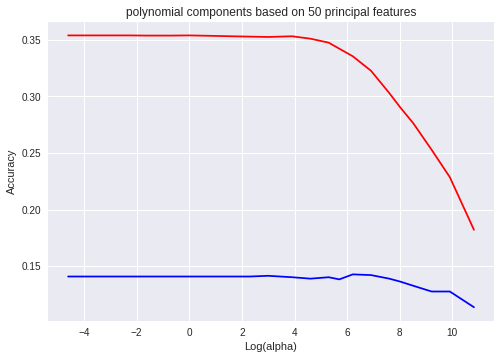

In [50]:
al, ac, ac_tr = train_ridge(vgg_bfPfull50)
plt.plot([np.log(i) for i in al], ac_tr, color='r')
plt.plot([np.log(i) for i in al], ac, color='b')
plt.title('polynomial components based on 50 principal features')
plt.xlabel('Log(alpha)')
plt.ylabel('Accuracy')
plt.show()



  0%|          | 0/15 [00:00<?, ?it/s]


  7%|▋         | 1/15 [00:57<13:22, 57.32s/it]

 13%|█▎        | 2/15 [01:53<12:20, 56.93s/it]

 20%|██        | 3/15 [02:48<11:18, 56.54s/it]

 27%|██▋       | 4/15 [03:44<10:17, 56.13s/it]

 33%|███▎      | 5/15 [04:39<09:17, 55.78s/it]

 40%|████      | 6/15 [05:34<08:22, 55.81s/it]

 47%|████▋     | 7/15 [06:31<07:27, 55.97s/it]

 53%|█████▎    | 8/15 [07:31<06:39, 57.11s/it]

 60%|██████    | 9/15 [08:30<05:46, 57.70s/it]

 67%|██████▋   | 10/15 [09:26<04:46, 57.29s/it]

 73%|███████▎  | 11/15 [10:20<03:45, 56.44s/it]

 80%|████████  | 12/15 [11:16<02:48, 56.20s/it]

 87%|████████▋ | 13/15 [12:13<01:53, 56.54s/it]

 93%|█████████▎| 14/15 [13:09<00:56, 56.36s/it]

100%|██████████| 15/15 [14:05<00:00, 56.10s/it]



Best accuracy: 0.147727272727
Best alpha: 200


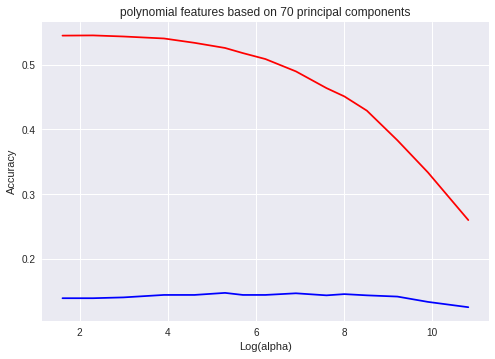

In [53]:
al, ac, ac_tr = train_ridge(vgg_bfPfull70, alphas = [5, 10, 20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000, 50000])
plt.plot([np.log(i) for i in al], ac_tr, color='r')
plt.plot([np.log(i) for i in al], ac, color='b')
plt.title('polynomial features based on 70 principal components')
plt.xlabel('Log(alpha)')
plt.ylabel('Accuracy')
plt.show()

100%|██████████| 7/7 [23:07<00:00, 210.98s/it]


Best accuracy: 0.150252525253
Best alpha: 5000


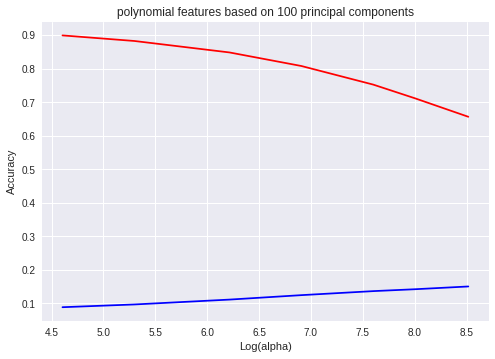

In [54]:
al, ac, ac_tr = train_ridge(vgg_bfPfull100, alphas = [100, 200, 500, 1000, 2000, 3000, 5000])
plt.plot([np.log(i) for i in al], ac_tr, color='r')
plt.plot([np.log(i) for i in al], ac, color='b')
plt.title('polynomial features based on 100 principal components')
plt.xlabel('Log(alpha)')
plt.ylabel('Accuracy')
plt.show()

100%|██████████| 6/6 [19:07<00:00, 185.25s/it]


Best accuracy: 0.153409090909
Best alpha: 10000


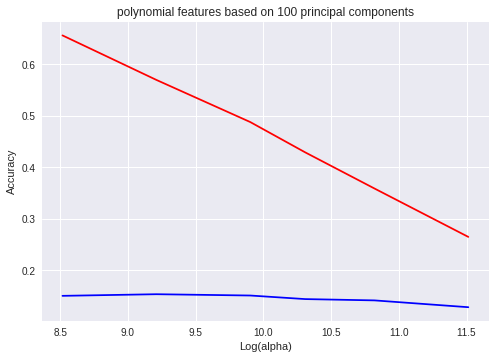

In [55]:
al, ac, ac_tr = train_ridge(vgg_bfPfull100, alphas = [5000, 10000, 20000, 30000, 50000, 100000])
plt.plot([np.log(i) for i in al], ac_tr, color='r')
plt.plot([np.log(i) for i in al], ac, color='b')
plt.title('polynomial features based on 100 principal components')
plt.xlabel('Log(alpha)')
plt.ylabel('Accuracy')
plt.show()

Наилучшая модель выбрана. Проверим ее на холдауте

In [56]:
vgg_bfPhold = pca.transform(vgg_scaler.transform(vgg_bf_holdout))
pol100 =[i[:100]  for i in vgg_bfPhold]
pol100 = [polynomizator(i) for i in pol100]
vgg_bfPhold100 = np.hstack([vgg_bfPhold, pol100])

In [64]:
img_fea = vgg_bfPfull100
img_fea1 = np.array(img_fea)[np.array([(i in b2v) for i in labels.breed.values[ftrain_idx]])]
X_train = img_fea1[train_idx]
X_valid = img_fea1[valid_idx]

X_hold = np.array(vgg_bfPhold100)[np.array([(i in b2v) for i in labels.breed.values[holdout_idx]])]
target_hold = [i for i in labels.breed.values[holdout_idx] if i in b2v]

predictions = []
predictions_train = []
predictions_hold  = []
for n in tqdm(range(len(y_train[0]))):
    regressor1 = Ridge(alpha=10000)
    regressor1.fit(X_train, [j[n] for j in y_train])
    prediction = regressor1.predict(X_valid)
    predictions.append(prediction)
    prediction = regressor1.predict(X_train)
    predictions_train.append(prediction)
    prediction = regressor1.predict(X_hold)
    predictions_hold.append(prediction)
predictions = [[i[n] for i in predictions] for n in range(len(predictions[0]))]
predictions_train = [[i[n] for i in predictions_train] for n in range(len(predictions_train[0]))]
predictions_hold  = [[i[n] for i in predictions_hold] for n in range(len(predictions_hold[0]))]
        
valid_preds=[]
ldistances=[]
for vect, trg in zip(predictions,target):
    distances = sorted([(i, np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[i],vect)]))) for i in b2v], key=lambda i: i[1])
    valid_preds.append(distances[0][0])
    distance_to_trg = np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[trg],vect)]))
    if(distances[0][1]!=0): ldistances.append([distances[0][1], distance_to_trg/distances[0][1], distances[1][1]/distances[0][1]])
print('Accuracy {}'.format(accuracy_score(target, valid_preds)))

train_preds=[]
for vect in predictions_train:
    distances = [(i, np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[i],vect)]))) for i in b2v]
    train_preds.append(sorted(distances, key=lambda i: i[1])[0][0])
print('Accuracy on train {}'.format(accuracy_score(target_train, train_preds)))

hold_preds=[]
for vect in predictions_hold:
    distances = [(i, np.sqrt(sum([(j[0]-j[1])**2 for j in zip(b2v[i],vect)]))) for i in b2v]
    hold_preds.append(sorted(distances, key=lambda i: i[1])[0][0])
print('Accuracy on holdout {}'.format(accuracy_score(target_hold, hold_preds)))

100%|██████████| 20/20 [02:29<00:00,  7.42s/it]


Accuracy 0.153409090909
Accuracy on train 0.569859670531
Accuracy on holdout 0.13976945245


In [66]:
bayesian = {}
for i in zip(train_preds, target_train):
    if i[0] not in bayesian:
        bayesian[i[0]] = np.array([0]*121)
    bayesian[i[0]][breed_dict[i[1]]]+=1

changer ={}
for i in bayesian:
    maximal=0
    bestbreed =''
    arr = bayesian[i]
    for breed in breed_dict:
        if(bayesian[i][breed_dict[breed]]<=maximal): continue
        maximal=bayesian[i][breed_dict[breed]]
        bestbreed=breed
    changer[i]=bestbreed

for breed in breed_dict:
    if breed not in changer:
        changer[breed]=breed

print('Accuracy on train {}'.format(accuracy_score(target_train, [changer[i] for i in train_preds])))
print('Accuracy on valid {}'.format(accuracy_score(target, [changer[i] for i in valid_preds])))
print('Accuracy on holdout {}'.format(accuracy_score(target_hold, [changer[i] for i in hold_preds])))

Accuracy on train 0.572300183038
Accuracy on valid 0.152777777778
Accuracy on holdout 0.137367915466


Ну что же, неплохой результат, учитывая, что мы начинали с точности в 6%. 

Последнее преобразование явно не дало никакого эффекта, так что регрессия явно стала лучше предсказывать с добавлением полиномиальных фич. Понятное дело можно развивать инжиниринг новых фич, но мощности моего компьютера на пределе, поэтому пора остановиться.

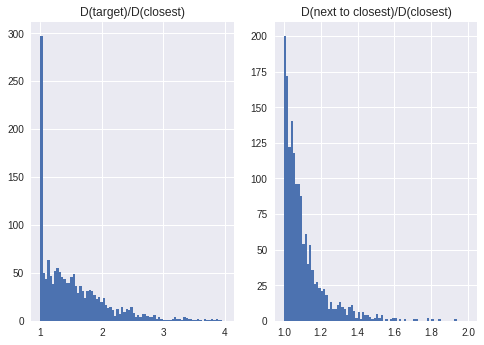

In [67]:
plt.figure(1)
plt.subplot(121)
plt.hist([i[1] for i in ldistances], bins=80, range=[1,4])
plt.title('D(target)/D(closest)')

plt.subplot(122)
plt.hist([i[2] for i in ldistances], bins=80, range=[1,2])
plt.title('D(next to closest)/D(closest)')
plt.show()

Видно, что предсказания стали зачастую идти ближе к цели, но расхождения все еще громадны. Дисперсия правого хвоста распределения изменилась довольно слабо, так что модель все еще просто не настроилась на значительную часть данных.

# Заключение

В целом я скорее оцениваю этот проект, как провальный в том виде, в котором он реализован сейчас. Ожидалось, что данные word2vec позволят кластеризовать метки классов так, что точность классификатора значимо улучшится, а этой цели добиться явно не удалось - точность упала в 4 раза. Очевидно, что дальше надо строить полиномиальные признаки 3 и 4 порядков, или же еще как-то модифицировать исходные данные но у меня совершенно точно не хватит ресурсов компьютера на такую задачу. Даже сейчас модель оказывается намного более тяжеловесной, чем я ожидал изначально.

Однако и сам проект пока и не закончен. В планах было использование нескольких готовых word2vec, тренированных на больших данных. Как мы видели, более широкий спектр статей википедии справился намного лучше узкого. Вероятно тренированный на больших данных word2vec также улучшил бы классификацию. Но готовые word2vec плохо помещаются в память моего компьютера. 

В планах было использовать картинки и тэги из iNaturalist challenge, но сотня гигабайт изображений опять же убила бы мой ноутбук еще на этапе предобработки (3 Гб вошедших сюда изображений обрабатывались около 2.5 часов). Также можно было попробовать использовать другие готовые сети, например XCeption, но это опять же ресурсоемкие задачи.

Я предполагаю, что с ростом статистики осмысленность векторов слов должна вырасти. Кроме того то позволит обучить более сложные модели. Сейчас вместо верхнего слоя нейронной сети, делающего предсказание в векторы слов стоит простая регрессия, или дерево, а это довольно глупо. Логично было бы достроить несколько своих полносвязных слоев на вершине нейронной сети, чтобы предсказывать векторы слов.

В общем...

# To be continued...

In [ ]:
# Впишите ваш код здесь